# Spectroscopic Data Reduction Part 3: Extracting the final wavelength-calibrated spectrum 

This tutorial assumes you have gone through the [Trace](1-SpectroscopicTraceTutorial.ipynb) and [Wavelength Calibration](2-WavelengthCalibration) tutorials and have their results available.

## Authors
Adam Ginsburg, Kelle Cruz, Lia Corrales, Jonathan Sick, Adrian Price-Whelan

## Learning Goals
* Extract a target 1D spectrum from a two-dimensional spectrum using an existing trace
* Apply a fitted wavelength solution to the data
* Fit a line profile to the wavelength-calibrated spectrum

## Keywords
Spectroscopy

## Summary
This tutorial, the third in a series, shows how to apply a trace and a wavelength solution to science data.  It then shows how to do basic analysis, i.e., line fitting.

In [1]:
with open('requirements.txt') as f:
    print(f"Required packages for this notebook:\n{f.read()}")

Required packages for this notebook:
astropy
astroquery>=0.4.8.dev9474  # 2024-09-24 pinned for Gaia column capitalization issue
IPython
numpy
pillow
matplotlib



## Extract the science spectrum

First, we repeat the trace-and-extract process derived in [Part 1](1-SpectroscopicTraceTutorial.ipynb), but now for Deneb:

In [2]:
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
from astropy.modeling.models import Linear1D
from astropy import constants
from astropy import units as u
from astropy.visualization import quantity_support
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x7fabd391f3b0>

In [4]:
image_array_2 = np.array(PILImage.open('deneb_3s_13.63g_1.bmp'))

In [5]:
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D
from astropy.modeling.fitting import LevMarLSQFitter, LinearLSQFitter
linfitter = LinearLSQFitter()

In [6]:
yaxis2 = np.repeat(np.arange(470, 520)[:,None], image_array_2.shape[1], axis=1)
xvals = np.arange(image_array_2.shape[1])
weighted_yaxis_values2 = np.average(yaxis2, axis=0, weights=image_array_2[470:520,:] - np.median(image_array_2))
polymodel2 = Polynomial1D(degree=3)
fitted_polymodel2 = linfitter(polymodel2, xvals, weighted_yaxis_values2)
trace_center2 = fitted_polymodel2(xvals)

In [7]:
npixels_to_cut = 15
trace_center = fitted_polymodel2(xvals)
cutouts = np.array([image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii]
                    for yval, ii in zip(trace_center, xvals)])
cutouts.shape
mean_trace_profile = cutouts.mean(axis=0)

In [8]:
spectrum2 = np.array([np.average(image_array_2[int(yval)-npixels_to_cut:int(yval)+npixels_to_cut, ii],
                                weights=mean_trace_profile)
                     for yval, ii in zip(trace_center2, xvals)])

Next, we retrieve the wavelength solution derived in Part 2.

In [9]:
wlmodel = Linear1D(slope=-0.10213643, intercept=562.3862495)

In [10]:
wavelengths = wlmodel(xvals) * u.nm

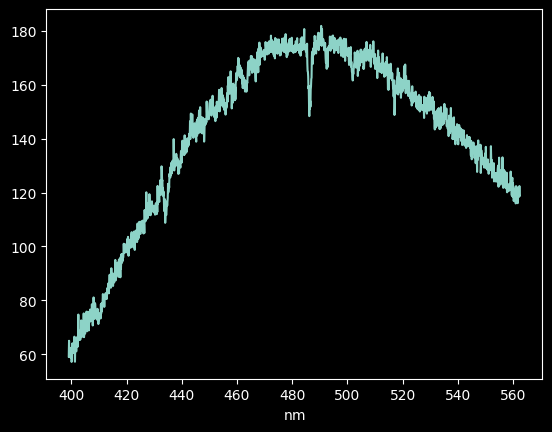

In [11]:
plt.plot(wavelengths, spectrum2)

# Analysis

Now, we go on to do some basic analysis on our fully extracted and wavelength-calibrated spectrum

We zoom in on the 4860 Angstrom line - H-Beta

(np.float64(470.0), np.float64(510.0), np.float64(140.0), np.float64(190.0))

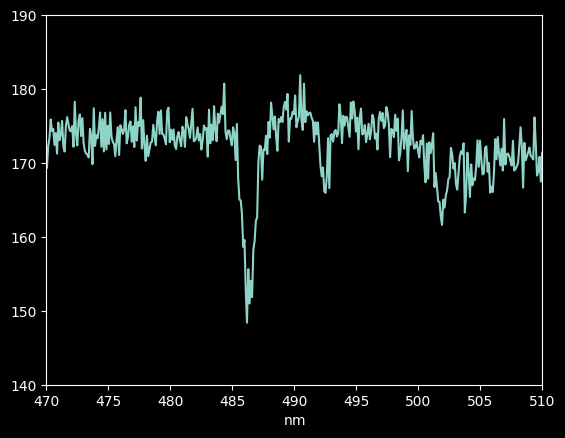

In [12]:
plt.plot(wavelengths, spectrum2)
plt.axis([470,510,140,190])

We can use astropy models to construct an absorption line model, consisting of a continuum level and a negative Gaussian to represent the absorption feature

In [13]:
absorption_model_guess = Linear1D(slope=0, intercept=175) + Gaussian1D(amplitude=-25, mean=486, stddev=3)

We can overplot our guessed model - it's not right, but it's in the right spot

(np.float64(470.0), np.float64(510.0), np.float64(140.0), np.float64(190.0))

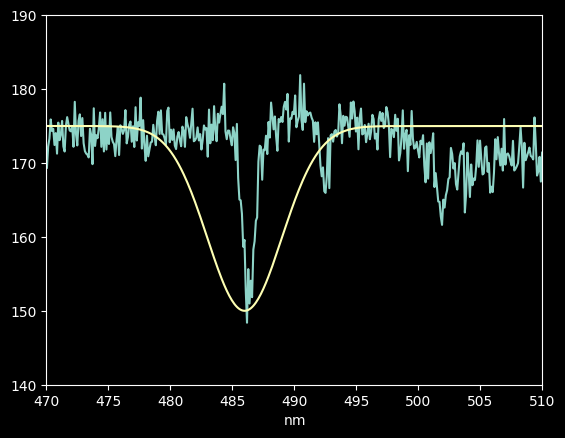

In [14]:
plt.plot(wavelengths, spectrum2)
plt.plot(wavelengths, absorption_model_guess(wavelengths.value))
plt.axis([470,510,140,190])

The Levenberg-Marquardt Least Squares fitter can be used to find the optimal fit to our data given the starting guess.

In [15]:
lmfitter = LevMarLSQFitter()
selection = (wavelengths > 470*u.nm) & (wavelengths < 500*u.nm) 
fitted_absorption_model = lmfitter(model=absorption_model_guess, x=wavelengths.value[selection], y=spectrum2[selection])

(np.float64(470.0), np.float64(510.0), np.float64(140.0), np.float64(190.0))

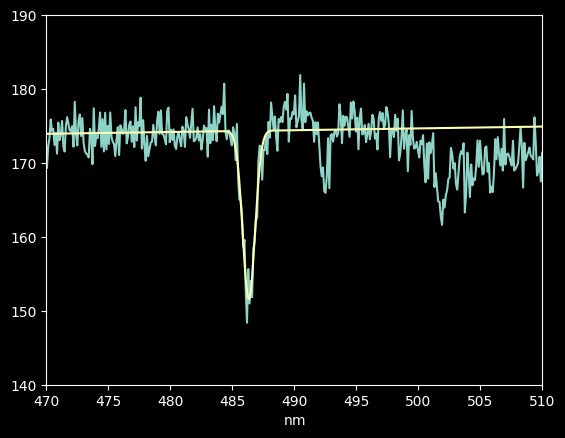

In [16]:
plt.plot(wavelengths, spectrum2)
plt.plot(wavelengths, fitted_absorption_model(wavelengths.value))
plt.axis([470,510,140,190])

We can now separate out the two components, the continuum and the absorption line model:

In [17]:
continuum_fit, absorption_fit = fitted_absorption_model

If we plot the data minus the absorption line model, we get a nice "line-free continuum":

(np.float64(470.0), np.float64(510.0), np.float64(140.0), np.float64(190.0))

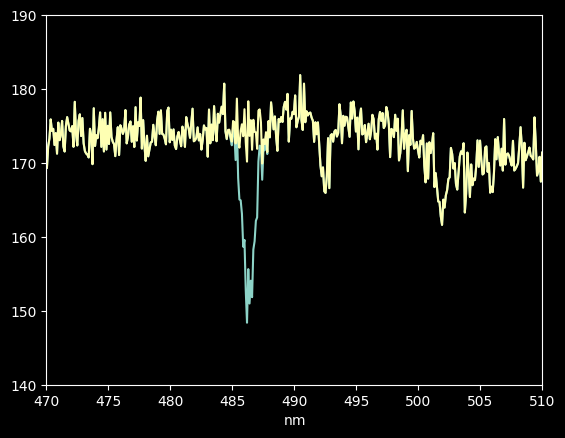

In [18]:
plt.plot(wavelengths, spectrum2)
plt.plot(wavelengths, spectrum2 - absorption_fit(wavelengths.value))
plt.axis([470,510,140,190])

The [Equivalent Width](https://en.wikipedia.org/wiki/Equivalent_width) of a spectral absorption line is defined to be the width of a feature that has the same integral as the absorption line, but goes all the way from the continuum level to zero.

We can compute this with our model, assuming our continuum is flat (has zero slope):

In [19]:
EQW =  -absorption_fit(wavelengths.value[selection]).sum() / continuum_fit.intercept * u.nm
EQW

<Quantity 1.71268556 nm>

In [20]:
absorption_fit

<Gaussian1D(amplitude=-22.81529847, mean=486.34296327, stddev=0.4969129)>

We have identified the line as H-beta, so we can measure some of its properties now:

In [21]:
air_wavelength_hbeta = 486.135*u.nm # wikipedia https://en.wikipedia.org/wiki/Balmer_series

The Doppler Shift will tell us the velocity of the star.  Note that this is the velocity in the _topocentric_ frame, i.e., in the rest frame of the observatory.  If we knew precisely when and where these observations were taken, we could convert this velocity to the heliocentric or LSR frames with [astropy tools](https://docs.astropy.org/en/stable/coordinates/velocities.html).

First, we do the calculation manually, following the optical definition
$$v_{opt} = c \frac{\lambda-\lambda_0}{\lambda} $$

In [22]:
doppler_velocity = (absorption_fit.mean*u.nm - air_wavelength_hbeta) / (air_wavelength_hbeta) * constants.c
doppler_velocity.to(u.km/u.s)

<Quantity 128.24795739 km / s>

We can do the same thing using [astropy equivalencies](https://docs.astropy.org/en/stable/units/equivalencies.html#spectral-doppler-equivalencies):

In [23]:
doppler_velocity = (absorption_fit.mean*u.nm).to(u.km/u.s, u.doppler_optical(air_wavelength_hbeta))
doppler_velocity

<Quantity 128.24795739 km / s>

We can also compute the line width from our fit:

In [24]:
linewidth_kms = (absorption_fit.stddev*u.nm) / air_wavelength_hbeta * constants.c.to(u.km/u.s)
linewidth_kms

<Quantity 306.43903635 km / s>

That's it!  You've extracted and wavelength-calibrated a spectrum.

The next tricky step is flux calibration, but we will do that in a subsequent tutorial because we need a different data set; this one didn't include the necessary data for flux calibration (though we could approximately calibrate the spectrum using a known magnitude over the observed band for Deneb)